In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub

TensorFlow 2.x selected.


In [0]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/labels.csv")

In [0]:
# labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [6]:
labels_csv["breed"].value_counts().median()

82.0

In [0]:
filenames = [fname for fname in labels_csv["id"]]

In [0]:
import numpy as np
labels = labels_csv["breed"].to_numpy()

In [9]:
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [0]:
boolean_labels = [label == unique_breeds for label in labels]
filenames = ["/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

In [0]:
X = filenames
y = boolean_labels

In [0]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10222}

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)  

In [0]:
def process_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[224,224])
  return image

In [0]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [0]:
def create_data_batches(X, y=None, batch_size=32, valid_data=False, test_data=False):
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(32)
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(32)
  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(32)
  return data_batch

In [0]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

In [18]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [0]:
import matplotlib.pyplot as plt

def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [0]:
# train_images, train_labels = next(train_data.as_numpy_iterator())

In [0]:
# show_25_images(train_images, train_labels)

In [0]:
# valid_images, valid_labels = next(valid_data.as_numpy_iterator())

In [0]:
# show_25_images(valid_images, valid_labels)

In [0]:
INPUT_SHAPE = [None, 224, 224, 3]
OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [0]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):

  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax")
  ])

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  model.build(INPUT_SHAPE)

  return model

In [26]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [27]:
outputs = np.ones(shape=(1,1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

In [0]:
%load_ext tensorboard
import datetime, os
def create_tensorboard_callback():
  logdir = os.path.join("/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [0]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callback() 
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model

In [0]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [0]:
# # model = train_model()
# model = load_model('/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Models/20200322-19471584906454-1000-images-mobilenetv2-Adam.h5')

In [0]:
# %tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/Dog\ Breed\ Identification/Logs

In [0]:
# predictions = model.predict(valid_data, verbose=1)

In [0]:
# predictions.shape, len(y_valid), len(unique_breeds)

In [0]:
def get_pred_label(prediction_probabilities):
  return unique_breeds[np.argmax(prediction_probabilities)]

In [0]:
def unbatchify(data):
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

valid_images, valid_labels = unbatchify(valid_data)

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

In [0]:
# plot_pred(prediction_probabilities=predictions,
#           labels=valid_labels,
#           images=valid_images,
#           n=7)

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  pred_label = get_pred_label(pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [0]:
# plot_pred_conf(prediction_probabilities=predictions,
#                labels=valid_labels,
#                n=9)

In [0]:
# multiplier = 20
# num_rows = 3
# num_cols = 2
# num_images = num_rows*num_cols
# plt.figure(figsize=(10*num_cols, 5*num_rows))
# for i in range(num_images):
#   plt.subplot(num_rows, 2*num_cols, 2*i+1)
#   plot_pred(prediction_probabilities=predictions,
#             labels=valid_labels,
#             images=valid_images,
#             n=i+multiplier)
#   plt.subplot(num_rows, 2*num_cols, 2*i+2)
#   plot_pred_conf(prediction_probabilities=predictions,
#                  labels=valid_labels,
#                  n=i+multiplier)
# plt.tight_layout(h_pad=1.0)
# plt.show()

In [0]:
def save_model(model, suffix=None):

  modeldir = os.path.join("/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:
# save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [0]:
# loaded_1000_image_model = load_model('/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Models/20200322-19471584906454-1000-images-mobilenetv2-Adam.h5')

In [0]:
# model.evaluate(valid_data)

In [0]:
# loaded_1000_image_model.evaluate(valid_data)

In [54]:
len(X), len(y)

(10222, 10222)

In [0]:
# full_data = create_data_batches(X, y)

In [0]:
# full_data

In [0]:
# full_model = create_model()

In [0]:
# full_model_tensorboard = create_tensorboard_callback()

# full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
#                                                              patience=3)

In [0]:
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [0]:
# save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

In [61]:
loaded_full_model = load_model('/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Models/20200322-21541584914073-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Models/20200322-21541584914073-full-image-set-mobilenetv2-Adam.h5


In [62]:
test_path = "/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f56080803871563e96541a57ad1a08c4.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f574f558d78db4e616e91f5dd5347409.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f540547111a9b6bda288b694a5536702.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f56185baca63dfc073ca82bee5bf24e4.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f56b3708592637432ac53d7f0684dfa8.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f56b4140707da82fe91cb9e5df4ce68c.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f575720280425098d6faca42cff69a36.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/test/f5787e3574a4af6a19ff825cf0c32366.jpg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/

In [63]:
len(test_filenames)

10366

In [64]:
test_data = create_data_batches(test_filenames, test_data=True)
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# test_predictions = loaded_full_model.predict(test_data,
#                                              verbose=1)

In [0]:
# np.savetxt("/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/preds_array.csv", test_predictions, delimiter=",")

In [68]:
test_predictions = np.loadtxt("/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/preds_array.csv", delimiter=",")
test_predictions[:10]

array([[1.68428343e-07, 2.00659533e-09, 2.71895800e-07, ...,
        6.46744520e-05, 1.10441897e-05, 7.99117606e-06],
       [7.01031316e-11, 9.92717981e-01, 3.32759886e-09, ...,
        2.95999769e-07, 3.35897887e-09, 1.45759129e-08],
       [9.04749129e-07, 3.39793189e-07, 2.43879697e-07, ...,
        1.22101351e-08, 1.63217908e-06, 8.53729085e-04],
       ...,
       [7.92449040e-09, 2.15825040e-07, 1.86912516e-07, ...,
        6.21308800e-06, 1.33797267e-08, 2.45236054e-09],
       [1.94868107e-07, 5.32226554e-11, 1.05973856e-12, ...,
        2.02497822e-13, 1.38496353e-10, 6.07095652e-10],
       [4.06220607e-07, 1.20439154e-07, 3.18562310e-09, ...,
        4.51644695e-08, 6.69555622e-04, 2.06159864e-04]])

In [69]:
test_predictions.shape

(10366, 120)

In [70]:
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [0]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [72]:
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f56080803871563e96541a57ad1a08c4,1.68428e-07,2.0066e-09,2.71896e-07,0.00375816,3.20432e-06,3.03003e-07,2.56905e-05,4.71382e-06,5.03148e-07,8.22257e-06,9.54712e-07,3.00155e-08,7.89066e-08,4.33537e-09,3.84114e-07,9.80845e-07,7.47731e-08,0.95378,5.81467e-11,2.51776e-05,1.28546e-07,2.94419e-06,6.91923e-05,2.55522e-08,1.05905e-08,1.02679e-05,3.35202e-07,1.24172e-09,9.48025e-07,8.62497e-07,8.44167e-10,2.48448e-07,2.14179e-10,7.54574e-09,1.31846e-07,9.40444e-06,1.37777e-07,1.56935e-07,1.16834e-05,...,1.28759e-05,1.04347e-05,3.37439e-08,4.48222e-07,8.6417e-09,5.10626e-09,2.48571e-08,8.35594e-09,6.3356e-07,8.77379e-07,3.02318e-07,4.30457e-06,5.67372e-10,2.72063e-08,4.00782e-09,3.04001e-07,6.80738e-08,5.07967e-06,6.03209e-06,4.49124e-10,3.83683e-07,1.57345e-08,7.99256e-06,2.03938e-06,8.90579e-05,9.74827e-09,0.0174188,2.82307e-07,8.65348e-07,4.176e-08,1.91335e-07,3.02188e-06,1.25017e-07,7.43062e-08,2.18737e-07,1.68566e-07,8.10107e-06,6.46745e-05,1.10442e-05,7.99118e-06
1,f574f558d78db4e616e91f5dd5347409,7.01031e-11,0.992718,3.3276e-09,7.39142e-09,1.10024e-08,1.64291e-09,6.50156e-08,4.43189e-11,1.72112e-09,2.69501e-11,1.82945e-08,2.28824e-08,1.97686e-08,1.00441e-07,2.92313e-08,3.48533e-07,3.50363e-07,7.77328e-12,0.000497781,2.02176e-10,8.41275e-10,2.75087e-10,2.71493e-11,5.26282e-06,9.94186e-09,5.21619e-09,2.40793e-09,4.10481e-08,1.47517e-07,3.83744e-10,2.86192e-07,5.77711e-07,0.000303569,0.00414085,4.04637e-09,2.3078e-07,3.12704e-10,2.32587e-09,2.36309e-08,...,6.95894e-12,1.91026e-06,2.47156e-06,2.03825e-05,3.51908e-10,1.97686e-08,4.72769e-09,6.17567e-08,1.92408e-10,1.9632e-08,2.29283e-06,2.56637e-09,1.53247e-08,0.00160542,4.79408e-07,1.40174e-11,1.86455e-09,1.61541e-06,1.6485e-10,3.44706e-08,2.8407e-09,5.96393e-09,3.65809e-10,6.82425e-09,4.91622e-09,1.60694e-05,1.67981e-08,1.88983e-07,1.2782e-05,2.18046e-05,5.44006e-08,1.78982e-11,1.16072e-08,9.27604e-06,1.32998e-05,9.08415e-08,5.78556e-10,2.96e-07,3.35898e-09,1.45759e-08
2,f540547111a9b6bda288b694a5536702,9.04749e-07,3.39793e-07,2.4388e-07,9.03917e-07,0.000185861,8.42934e-09,1.89463e-05,3.357e-07,1.41203e-06,1.6623e-08,2.63268e-10,1.14919e-07,3.23985e-06,2.31828e-05,2.25078e-05,8.69907e-07,3.05464e-06,6.36041e-06,4.64615e-08,8.28516e-06,2.39929e-06,9.74281e-06,0.00266963,0.000311962,2.33952e-07,0.301535,3.15604e-06,5.82842e-08,4.55468e-07,1.33826e-07,2.04539e-06,5.76087e-05,6.67501e-05,1.12455e-06,5.54405e-11,1.04669e-06,4.77694e-10,9.23696e-08,1.67511e-07,...,1.66336e-07,4.4558e-05,2.0016e-05,2.1301e-06,7.20817e-06,0.00336257,1.65089e-09,1.27444e-07,0.0398891,1.18131e-06,5.33509e-07,1.4709e-05,9.9243e-05,4.243e-08,7.80701e-09,1.65201e-07,1.3388e-08,1.48038e-07,3.88015e-08,3.28685e-07,0.00537218,2.48878e-08,0.641569,1.17839e-06,6.19597e-05,2.25992e-07,2.30971e-06,1.03963e-05,0.000137166,0.0001337,1.97868e-07,8.04323e-07,1.41517e-08,1.95726e-07,3.58892e-07,8.77703e-07,1.86744e-07,1.22101e-08,1.632

In [0]:
preds_df.to_csv("/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

In [74]:
custom_path = "/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/new/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/new/dog-photo-2.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/new/dog-photo-1.jpeg',
 '/content/drive/My Drive/Colab Notebooks/Dog Breed Identification/Data/new/dog-photo-3.jpeg']

In [75]:
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [76]:
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape

(3, 120)

In [77]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['lakeland_terrier', 'golden_retriever', 'labrador_retriever']

In [0]:
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

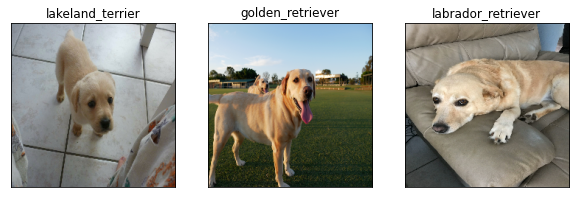

In [79]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)